In [3]:
# downgrade to version 1.2.2
pip install keras==1.2.2

     |████████████████████████████████| 184kB 6.4MB/s 
  Created wheel for keras: filename=Keras-1.2.2-cp36-none-any.whl size=209603 sha256=a69a2f58135eef0afdc967a7c545a5a0919495b640125105092fdd5bc7bc524e
  Stored in directory: /root/.cache/pip/wheels/55/07/cf/b32db0a8d243b2fd6759d5d7cb650aa20670b2b740209cbf7e
Successfully built keras
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 1.2.2 which is incompatible.
ERROR: kapre 0.1.3.1 has requirement keras>=2.0.0, but you'll have keras 1.2.2 which is incompatible.
ERROR: fancyimpute 0.4.3 has requirement keras>=2.0.0, but you'll have keras 1.2.2 which is incompatible.
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [4]:
# imports
import glob
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Merge, Dropout, Input, merge
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk

Using TensorFlow backend.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive/Colab Notebooks/520 Final project"

520final.ipynb			   time_inceptionV3_1.5987_loss.h5
encoded_images_inceptionV3.p	   unique.p
encoded_images_test_inceptionV3.p  unique_words.p
encoded_images_val_inceptionV3.p   weights_1.h
Flickr8k			   weights_2.h
images_filename.p		   weights_3.h


In [0]:
# get captions
token = "/content/drive/My Drive/Colab Notebooks/520 Final project/Flickr8k/Flickr8k_text/Flickr8k.token.txt"
captions = open(token, 'r').read().strip().split('\n')

In [0]:
# create dic
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [6]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [0]:
# get image data
images = '/content/drive/My Drive/Colab Notebooks/520 Final project/Flickr8k/Flicker8k_Dataset/'
img = glob.glob(images+'*.jpg')

In [0]:
with open("/content/drive/My Drive/Colab Notebooks/520 Final project/images_filename.p", "wb") as img_pickle:
    pickle.dump(img, img_pickle)

In [0]:
img = pickle.load(open("/content/drive/My Drive/Colab Notebooks/520 Final project/images_filename.p", 'rb'))

In [0]:
train_images_file = '/content/drive/My Drive/Colab Notebooks/520 Final project/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_file = '/content/drive/My Drive/Colab Notebooks/520 Final project/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
val_images_file = '/content/drive/My Drive/Colab Notebooks/520 Final project/Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt'
train_img = list(open(train_images_file, 'r').read().strip().split('\n'))
test_img = list(open(test_images_file, 'r').read().strip().split('\n'))
val_img = list(open(val_images_file, 'r').read().strip().split('\n'))

In [11]:
print("train_img: {}, test_img: {}, val_img: {}".format(len(train_img), len(test_img), len(val_img)))

train_img: 6000, test_img: 1000, val_img: 1000


Text(0.5, 1.0, 'A black dog is running after a white dog in the snow .')

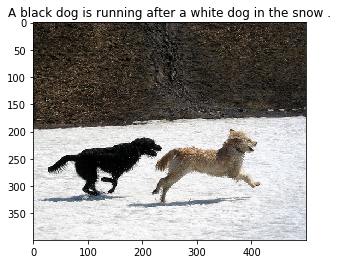

In [12]:
plt.imshow(Image.open(images + train_img[0]))
plt.title(d[train_img[0]][0])

In [0]:
# resize and scale to -1 to 1
def preprocess(image_name):
    img = np.array(Image.open(images + image_name))
    img = cv2.resize(img, (299, 299), interpolation = cv2.INTER_AREA)
    processed_img = np.expand_dims(img, axis=0)
    processed_img = (processed_img / 255 - 0.5) * 2
    return processed_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'A black dog is running after a white dog in the snow .')

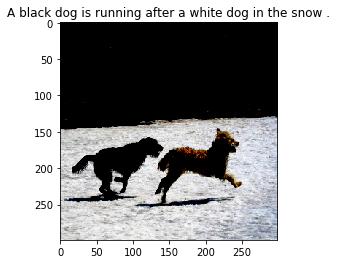

In [13]:
plt.imshow(np.squeeze(preprocess(train_img[0])))
plt.title(d[train_img[0]][0])

In [0]:
# InceptionV3 encoder
from keras.models import Model
# Use the hidden layer as output
model = InceptionV3(weights='imagenet')
new_input = model.input
hidden_layer = model.layers[-2].output
model_new = Model(new_input, hidden_layer)

In [0]:
def encode_img(img):
  img = preprocess(img)
  encoded_img = model_new.predict(img)
  encoded_img = np.reshape(encoded_img, encoded_img.shape[1])
  return encoded_img

In [39]:
train_img

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg',
 '218342358_1755a9cce1.jpg',
 '2501968935_02f2cd8079.jpg',
 '2699342860_5288e203ea.jpg',
 '2638369467_8fc251595b.jpg',
 '2926786902_815a99a154.jpg',
 '2851304910_b5721199bc.jpg',
 '3423802527_94bd2b23b0.jpg',
 '3356369156_074750c6cc.jpg',
 '2294598473_40637b5c04.jpg',
 '1191338263_a4fa073154.jpg',
 '2380765956_6313d8cae3.jpg',
 '3197891333_b1b0fd1702.jpg',
 '3119887967_271a097464.jpg',
 '2276499757_b44dc6f8ce.jpg',
 '2506892928_7e79bec613.jpg',
 '2187222896_c206d63396.jpg',
 '2826769554_85c90864c9.jpg',
 '3097196395_ec06075389.jpg',
 '3603116579_4a28a932e2.jpg',
 '3339263085_6db9fd0981.jpg',
 '2532262109_87429a2cae.jpg',
 '2076906555_c20dc082db.jpg',
 '2502007071_82a8c639cf.jpg',
 '3113769557_9edbb8275c.jpg',
 '3325974730_3ee192e4ff.jpg',
 '1655781989_b15ab4cbff.jpg',
 '1662261486_db967930de.jpg',
 '2410562803_56ec09f41c.jpg',
 '2469498117

In [40]:
# generate encoded image data
encoded_train = {}
for img in tqdm(train_img):
    encoded_train[img] = encode_img(img)



  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 3/6000 [00:00<04:17, 23.28it/s]

  0%|          | 6/6000 [00:00<04:15, 23.44it/s]

  0%|          | 9/6000 [00:00<04:18, 23.14it/s]

  0%|          | 12/6000 [00:00<04:17, 23.26it/s]

  0%|          | 15/6000 [00:00<04:17, 23.25it/s]

  0%|          | 18/6000 [00:00<04:14, 23.53it/s]

  0%|          | 21/6000 [00:00<04:22, 22.79it/s]

  0%|          | 24/6000 [00:01<04:24, 22.63it/s]

  0%|          | 27/6000 [00:01<04:17, 23.23it/s]

  0%|          | 30/6000 [00:01<04:15, 23.41it/s]

  1%|          | 33/6000 [00:01<04:19, 23.03it/s]

  1%|          | 36/6000 [00:01<04:15, 23.33it/s]

  1%|          | 39/6000 [00:01<04:21, 22.76it/s]

  1%|          | 42/6000 [00:01<04:22, 22.71it/s]

  1%|          | 45/6000 [00:01<04:17, 23.10it/s]

  1%|          | 48/6000 [00:02<04:21, 22.78it/s]

  1%|          | 51/6000 [00:02<04:17, 23.12it/s]

  1%|          | 54/6000 [00:02<04:15, 23.26it/s]

  1%|          | 57/6000 [00:02<04:18, 23

In [0]:
# with open("/content/drive/My Drive/Colab Notebooks/520 Final project/encoded_images_inceptionV3.p", "wb") as encoded_pickle:
#     pickle.dump(encoded_train, encoded_pickle)

In [0]:
# encoded_val = {}
# for img in tqdm(val_img):
#     encoded_val[img[len(images):]] = encode_img(img)

100%|██████████| 1000/1000 [10:27<00:00,  1.77it/s]


In [0]:
# with open("/content/drive/My Drive/Colab Notebooks/520 Final project/encoded_images_val_inceptionV3.p", "wb") as encoded_pickle:
#     pickle.dump(encoded_val, encoded_pickle)

In [0]:
# Run this to get the training data
encoded_train = pickle.load(open("/content/drive/My Drive/Colab Notebooks/520 Final project/encoded_images_inceptionV3.p", 'rb'))

In [15]:
len(encoded_train)

6000

In [0]:
# Run this to get the test data
encoded_test = pickle.load(open("/content/drive/My Drive/Colab Notebooks/520 Final project/encoded_images_test_inceptionV3.p", 'rb'))

We may append the output of YOLO afterwards

In [0]:
# Get the train dic
train_d = {}
for i in train_img:
    if i in d:
        train_d[i] = d[i]

In [0]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [0]:
# #Unique words for vocabulart

# words = [i.split() for i in caps]

# unique = []
# for i in words:
#     unique.extend(i)
# unique = list(set(unique))

In [0]:
# with open("/content/drive/My Drive/Colab Notebooks/520 Final project/unique.p", "wb") as encoded_pickle:
#     pickle.dump(unique, encoded_pickle)

In [0]:
unique = pickle.load(open("/content/drive/My Drive/Colab Notebooks/520 Final project/unique.p", 'rb'))

In [0]:
word2idx = {val:index for index, val in enumerate(unique)}
idx2word = {index:val for index, val in enumerate(unique)}

In [49]:
word2idx['<start>']

459

In [52]:
idx2word[459]


'<start>'

In [0]:
vocab_size = len(unique)

In [22]:
vocab_size

8256

In [23]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [0]:
for key, val in train_d.items():
    for i in val:
        f.write(key + "\t" + "<start> " + i +" <end>" + "\n")
f.close()

In [25]:
# generate the dataframe to access the data
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
display(df)

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...
...,...,...
29995,2671602981_4edde92658.jpg,<start> A little girl in a bathing suit leaps ...
29996,2671602981_4edde92658.jpg,<start> A little girl wearing a black tankini ...
29997,2671602981_4edde92658.jpg,<start> A young girl in a swimming suit jumps ...
29998,2671602981_4edde92658.jpg,<start> A young girl jumping out of the water ...


In [0]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [29]:
samples_per_epoch

383454

In [30]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [0]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoded_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [0]:
embedding_size = 300

In [33]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [34]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [35]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

In [36]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [37]:
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 300)           614700                                       
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 40, 300)       0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 40, 300)       2476800                                      
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 40, 256)       570368                                       
___________________________________________________________________________________________

In [38]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=10, 
                          verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10







/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


924s - loss: 3.9656 - acc: 0.3259
Epoch 2/10
913s - loss: 3.4651 - acc: 0.3903
Epoch 3/10
913s - loss: 3.3585 - acc: 0.4052
Epoch 4/10
946s - loss: 3.3696 - acc: 0.4152
Epoch 5/10
952s - loss: 3.3329 - acc: 0.4219
Epoch 6/10
959s - loss: 3.2608 - acc: 0.4291
Epoch 7/10
961s - loss: 3.2739 - acc: 0.4334
Epoch 8/10
955s - loss: 3.2657 - acc: 0.4395
Epoch 9/10
947s - loss: 3.2169 - acc: 0.4447
Epoch 10/10
934s - loss: 3.2129 - acc: 0.4489


In [0]:
final_model.save_weights('/content/drive/My Drive/Colab Notebooks/520 Final project/weights_111.h')

In [0]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=10, 
                          verbose=2)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


1019s - loss: 3.2775 - acc: 0.4505
Epoch 2/10
1001s - loss: 3.2611 - acc: 0.4560
Epoch 3/10
1010s - loss: 3.2401 - acc: 0.4600
Epoch 4/10
1011s - loss: 3.2153 - acc: 0.4651
Epoch 5/10
1010s - loss: 3.1817 - acc: 0.4692
Epoch 6/10
1014s - loss: 3.1628 - acc: 0.4741
Epoch 7/10
1012s - loss: 3.1391 - acc: 0.4776
Epoch 8/10
1009s - loss: 3.1038 - acc: 0.4813
Epoch 9/10
1003s - loss: 3.0969 - acc: 0.4841
Epoch 10/10
1012s - loss: 3.0927 - acc: 0.4874


In [0]:
final_model.save_weights('/content/drive/My Drive/Colab Notebooks/520 Final project/weights_222.h')

In [97]:
final_model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=10, 
                          verbose=2)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


1020s - loss: 3.1468 - acc: 0.4816
Epoch 2/10
1009s - loss: 3.1224 - acc: 0.4844
Epoch 3/10
989s - loss: 3.1067 - acc: 0.4885
Epoch 4/10
987s - loss: 3.1006 - acc: 0.4920
Epoch 5/10
993s - loss: 3.0701 - acc: 0.4943
Epoch 6/10
998s - loss: 3.0659 - acc: 0.4965
Epoch 7/10
999s - loss: 3.0624 - acc: 0.4976
Epoch 8/10
997s - loss: 3.0411 - acc: 0.4994
Epoch 9/10
997s - loss: 3.0245 - acc: 0.5034
Epoch 10/10
996s - loss: 3.0161 - acc: 0.5043


In [0]:
final_model.save_weights('/content/drive/My Drive/Colab Notebooks/520 Final project/weights_33.h')

In [0]:
final_model.load_weights('/content/drive/My Drive/Colab Notebooks/520 Final project/weights_11.h')

In [0]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoded_test[image]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

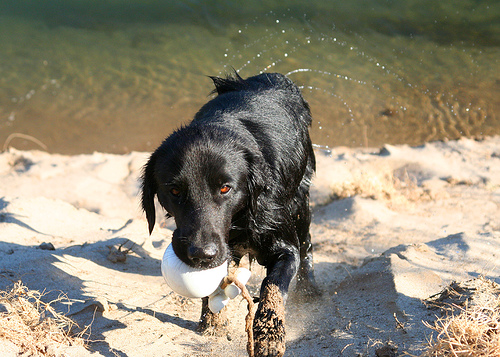

In [47]:
Image.open(images+ test_img[8])

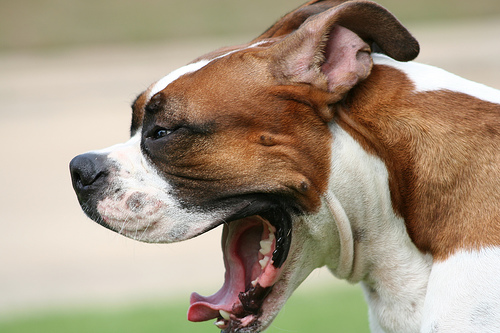

In [52]:
Image.open(images + test_img[7])

In [48]:
predict_captions(test_img[8])

'Man smiling smiling at baby baby baby baby baby baby baby baby baby baby baby baby baby baby baby baby baby baby baby baby baby baby baby baby baby baby kids Asian kids football .'